In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=96)
df.to_pickle('/tmp/df_horizon96_price_type_none.pkl')
display(df)

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6 * 4, 12 * 4, 24 * 4, 36 * 4, 48 * 4, 72 * 4, 96 * 4]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-10-29 16:41:26.214492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 16:41:26.338846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-29 16:41:26.338881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-29 16:41:26.365804: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-29 16:41:27.040164: W tensorflow/stream_executor/platform/de

In [5]:
# https://github.com/CyberZHG/keras-drop-connect/blob/master/LICENSE

from inspect import getfullargspec

class GaussianDropConnect(tf.keras.layers.Wrapper):
    def __init__(self, layer, rate=0.0, seed=None, **kwargs):
        super(GaussianDropConnect, self).__init__(layer, **kwargs)
        if isinstance(rate, dict):
            for name in list(rate.keys()):
                rate[name] = min(1., max(0., rate[name]))
        else:
            rate = min(1., max(0., rate))
        self.rate = rate
        self.seed = seed
        self.supports_masking = self.layer.supports_masking

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
        super(GaussianDropConnect, self).build()
        
        def dropped_weight(weight, drop_connect_rate):
            sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
            def _dropped_weight():
                return weight * tf.keras.backend.random_normal(
                    shape=tf.shape(weight),
                    mean=1.0,
                    stddev=sigma,
                    dtype=weight.dtype,
                    seed=self.seed
                )
                return dropped
            return _dropped_weight

        training = None
        
        weights = []
        for w in self.layer.trainable_weights:
            weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        self.layer.trainable_weights = weights
        
    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def compute_mask(self, inputs, mask=None):
        return self.layer.compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        def has_arg(fn, name):
            arg_spec = getfullargspec(fn)
            return name in arg_spec.args or name in arg_spec.kwonlyargs

        kwargs = {}
        if has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if has_arg(self.layer.call, 'mask'):
            kwargs['mask'] = mask

#         def dropped_weight(weight, drop_connect_rate):
#             sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
#             def _dropped_weight():
#                 return weight * tf.keras.backend.random_normal(
#                     shape=tf.shape(weight),
#                     mean=1.0,
#                     stddev=sigma,
#                     dtype=weight.dtype,
#                     seed=self.seed
#                 )
#                 return dropped
#             return _dropped_weight

#         origins = self.layer.trainable_weights
        
#         # origins = {}
#         if isinstance(self.rate, dict):
#             for name, rate in self.rate.items():
#                 w = getattr(self.layer, name)
#                 if w in self.layer.trainable_weights:
#                     origins[name] = w
#                     if 0. < rate < 1.:
#                         setattr(self.layer, name, )
#         else:
#             weights = []
#             for w in self.layer.trainable_weights:
#                 weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
#             self.layer.set_weights(weights)
                    
# #             for name in dir(self.layer):
# #                 try:
# #                     w = getattr(self.layer, name)
# #                 except Exception as e:
# #                     continue
                
# #                 if w in self.layer.trainable_weights:
# #                     origins[name] = w
# #                     if 0. < self.rate < 1.:
# #                         setattr(self.layer, name, tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        outputs = self.layer.call(inputs, **kwargs)
        # for name, w in origins.items():
        #     setattr(self.layer, name, w)
        # self.layer.set_weights(origins)
        return outputs

    def get_config(self):
        config = {
            'rate': self.rate,
            'seed': self.seed,
        }
        base_config = super(GaussianDropConnect, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [7]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [8]:
class WeightShuffleCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 20:
            return
        
        weights = self.model.get_weights()
        for i in range(0, len(weights)):
        # for i in range(len(weights) // 2, len(weights)):
            w = weights[i]
            if False:
            # if len(w.shape) == 1:
                w[:] = 0.0
            else:
                # flatten shuffle
                w = np.random.permutation(w.flatten()).reshape(w.shape)
                # axis 0 shuffle
                # w = np.random.permutation(w)
                # axis 1 shuffle 
                # maybe overfit
                # if len(w.shape) == 2:
                #     w = np.random.permutation(w.T).T
                # else:
                #     w = np.random.permutation(w)
            weights[i] = w

        self.model.set_weights(weights)


In [9]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [10]:
# https://arxiv.org/pdf/2002.08253.pdf
class MarsConstraint(tf.keras.constraints.Constraint):
    def __init__(self, gamma):
        self.gamma = gamma
        self.initial_weight = None

    def __call__(self, w):
        w = w - self.initial_weight
        norms = tf.keras.backend.sum(tf.keras.backend.abs(w), axis=range(len(w.shape) - 1), keepdims=True)
        w *= (1.0 / tf.keras.backend.maximum(1.0, norms / self.gamma))
        w += self.initial_weight
        return w

    def get_config(self):
        return { "gamma": self.gamma }

In [11]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [12]:
class WeightMACallback(tf.keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs=None):
        if hasattr(self, '_prev_weights'):
            self.model.set_weights(self._prev_weights)

    def on_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        
        decay = 0.99
        
        avg_weights = []
        if not hasattr(self, '_sum_weights'):
            self._sum_weights = weights
            self._sum_count = 1
        else:
            self._sum_count += 1
            for i in range(len(weights)):
                # self._sum_weights[i] += weights[i]
                self._sum_weights[i] = self._sum_weights[i] * decay + weights[i] * (1 - decay)
                # avg_weights += [self._sum_weights[i] / self._sum_count]
            self._prev_weights = weights
            # self.model.set_weights(avg_weights)
            self.model.set_weights(self._sum_weights)
        

In [13]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [14]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    # WeightMACallback(),
                    es,
                    # WeightLenCallback(),
                    # tb, # last
                ],
                batch_size=4096 * 8,
                # batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            keras_model = models[i][1].model_
            keras_model.optimizer.assign_average_vars(keras_model.variables)

            models[i][1] = SimpleKerasPredictor(keras_model)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # not bad
#     x = Dense(size ** 4, use_bias=True, 
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size, size, size))(x)
    
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    
    # good
#     reg_cnn = reg
#     # reg_cnn = regularizers.l2(1e-3 * size ** 2)
#     reg_cnn1 = DistanceL2(l2_dist)
#     cnn1 = Dense(size ** 3,
#              # activation='relu',
#              use_bias=True,
#              # use_bias=False, # bad ?
#              kernel_regularizer=reg, 
#              # kernel_regularizer=reg_cnn1,
#              # kernel_regularizer=reg_l1, 
#              bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#     )
#     x = cnn1(x)
#     # x = Dropout(0.9)(x)
#     x = Reshape((size, size, size))(x)
    
#     reg_cnn2 = DistanceL2(l2_dist)
#     cnn2 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn, 
#                # kernel_regularizer=reg_cnn2, 
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn2(x)
#     # x = Dropout(0.9)(x)
#     reg_cnn3 = DistanceL2(l2_dist)
#     cnn3 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn,
#                # kernel_regularizer=reg_cnn3,
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn3(x)
    # x = Dropout(0.9)(x)
    
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    # x = Flatten()(x)
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    
#     x = Dense(size ** 2, use_bias=True,
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size))(x)
    
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    # x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.5)(x)
    
    # x = MaxPooling1D(pool_size=4, strides=2)(x)
    # x = AveragePooling1D(pool_size=4, strides=2)(x)
    # x = Flatten()(x)
    
    # x = tf.keras.layers.GaussianNoise(0.5)(x)
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    reg1 = DistanceL2(l2_dist)
    # d1 = tfa.layers.NoisyDense(
    # d1 = Dense(
    #     256,
    #     # size,
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg1,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d1(x)
    # x = BatchNormalization()(x)
    # x = Concatenate()([x, inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    reg2 = DistanceL2(l2_dist)
    d2_inputs = x
    # d2 = tfa.layers.NoisyDense(
    # d2 = Dense(
    #     # 64, 
    #     128,
    #     # 512,
    #     # size, 
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg2,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d2(x)
    # x = Concatenate()([x, inputs, d2_inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        mars_constraint = MarsConstraint(8)
        mars_constraints.append(mars_constraint)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        # dense1 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense1)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         # dense = GaussianDropConnectDense(
#         dense2 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense2)
        
#         u = dense1(x)
#         v = dense2(x)
#         x = Concatenate()([Add()([u, v]), Subtract()([u, v])])
#         x = Rescaling(0.5 ** 0.5)(x)
#         x = Activation(act)(x)
        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    opt = tfa.optimizers.MovingAverage(opt)
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # 0.18 1.3 drop connect sigma 0.5 2e-4
    # 0.15 1.1 drop connect sigma 0.5 2e-4 es 40
    # 0.17 1.2 2e-4
    # todo 1e-4
    # 0.164 1.0 drop connect sigma 0.5 2e-3 
    # 0.135 1.0 2e-3
    # 0.17 1.1 2e-3 dist l2 1e-4
    # 0.170 1.35 2e-3 dist l2 0 elu
    # 0.182 1.44 2e-3 dist l2 0 elu mixout(weight)
    # 0.182 1.37 2e-4 dist l2 0 elu mixout(weight)
    # 0.191 1.52 2e-4(patient40) dist l2 0 elu mixout(weight) https://gist.github.com/richmanbtc/e3b7b480466e425ee12223e476b2643e
    # 0.165 1.14 adabelief dist l2 0 elu last layer zeros no output rescaling
    # 0.159 1.14 adabelief dist l2 0 elu last layer zeros
    # 0.182 1.24 adabelief dist l2 0 elu batch 512 lr 0.001 / 8
    # 0.173 1.32 adabelief dist l2 0 elu batch 64 lr 0.001 / 64
    # 0.172 1.47 adabelief dist l2 0 elu smooth
    # 0.169 1.41 adabelief dist l2 0 elu smooth unit 128
    # 0.161 1.24 adabelief dist l2 0 elu smooth unit 128 last pooling 2
    # 0.164 1.25 adabelief dist l2 0 elu smooth 4
    # 0.183 1.47 adabelief dist l2 0 elu mixout(weight, 0.5)
    # 0.180 1.36 adabelief dist l2 0 elu mixout(weight, 0.7)
    # 0.180 1.35 adabelief dist l2 0 elu mixout(weight, 0.3)
    # 0.176 1.46 adabelief dist l2 0 elu
    # 0.180 1.60 adabelief dist l2 0 elu output gaussian dropout 0.5 work1:https://gist.github.com/richmanbtc/da475809b4da464de864f661db7ab033
    # 0.183 1.61 adabelief dist l2 0 elu output dropout 0.5
    # 0.191 1.55 adabelief dist l2 0 elu output dropout 0.5 mixout(weight, 0.5)
    # 0.168 1.11 adabelief dist l2 0 elu no dropout
    # 0.159 1.28 adabelief dist l2 0 elu no dropout output l2 0.01
    # 0.187 1.57 2e-4 dist l2 0 elu output dropout 0.5
    # 0.178 1.40 adabelief dist l2 1e-4 elu
    # 0.163 1.27 adabelief dist l2 0 elu dropout 0.995 unit 128
    # 0.177 1.40 adabelief dist l2 0 elu unit 128 mixout(weight, 0.5)
    # 0.193 1.52 adabelief dist l2 0 elu mars 8 https://gist.github.com/richmanbtc/1a86fa1e40c5afad8de129373cabe372
    # 0.163 1.19 adabelief dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.185 1.47 2e-4 dist l2 0 elu mars 8
    # 0.185 1.37 2e-4 dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.180 1.38 2e-3 dist l2 0 elu gaussian mixout(weight)
    # 0.156 1.18 2e-3 dist l2 0 elu 6 layer
    # 0.150 1.09 2e-3 dist l2 0 relu 6 layer
    # 0.154 1.22 2e-3 dist l2 1e-4 relu 6 layer
    # 0.155 1.18 2e-3 dist l2 1e-4 elu 6 layer
    # 0.165 1.20 2e-3 dist l2 0 elu mixout(weight) 6 layer
    # 0.155 1.32 2e-3 dist l2 0 elu gaussian mixout(weight) 6 layer
    # 0.168 1.34 2e-3 dist l2 0 elu mixout(weight) 4 layer
    # 0.170 1.32 2e-3 dist l2 1e-4 elu
    # 0.175 1.31 2e-3 dist l2 1e-4 elu mixout(weight)
    # 0.185 1.37 2e-4 dist l2 1e-4 relu
    # 0.187 1.48 2e-4 dist l2 1e-4 elu https://gist.github.com/richmanbtc/0d4f571b5bc21b590934e4930b54a21e
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (197936, 730)


2022-10-29 16:41:35.443088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-29 16:41:35.443150: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-29 16:41:35.443192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (65854e213ab4): /proc/driver/nvidia/version does not exist
2022-10-29 16:41:35.443437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
5/5 - 3s - loss: 1.1323 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0639 - val_loss: 0.6881 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.5406e-03 - 3s/epoch - 563ms/step
Epoch 2/1000
5/5 - 1s - loss: 1.1322 - mse: 1.0001 - weighted_mse: 0.9987 - cosine_similarity: 0.0647 - val_loss: 0.6881 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -4.2641e-03 - 876ms/epoch - 175ms/step
Epoch 3/1000
5/5 - 1s - loss: 1.1320 - mse: 1.0001 - weighted_mse: 0.9985 - cosine_similarity: 0.0717 - val_loss: 0.6881 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.6178e-03 - 917ms/epoch - 183ms/step
Epoch 4/1000
5/5 - 1s - loss: 1.1316 - mse: 1.0002 - weighted_mse: 0.9982 - cosine_similarity: 0.0825 - val_loss: 0.6881 - val_mse: 1.0005 - val_weighted_mse: 1.0001 - val_cosine_similarity: 0.0024 - 895ms/epoch - 179ms/step
Epoch 5/1000
5/5 - 1s - loss: 1.1311 - mse: 1.0002 - weig

INFO:tensorflow:Assets written to: /tmp/tmpsw5w9r1v/assets
2022-10-29 16:57:52.312116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:57:52.312194: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:57:52.312929: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsw5w9r1v
2022-10-29 16:57:52.314757: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:57:52.314796: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsw5w9r1v
2022-10-29 16:57:52.320435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-29 16:57:52.322262: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:57:52.395524: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpkumbezvi/assets


INFO:tensorflow:Assets written to: /tmp/tmpkumbezvi/assets
2022-10-29 16:57:53.971382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:57:53.971457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:57:53.971634: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkumbezvi
2022-10-29 16:57:53.973376: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:57:53.973414: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkumbezvi
2022-10-29 16:57:53.979378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:57:54.050986: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkumbezvi
2022-10-29 16:57:54.066535: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvtsh852r/assets


INFO:tensorflow:Assets written to: /tmp/tmpvtsh852r/assets
2022-10-29 16:57:55.545984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:57:55.546109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:57:55.546288: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvtsh852r
2022-10-29 16:57:55.547959: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:57:55.547996: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvtsh852r
2022-10-29 16:57:55.555601: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:57:55.634126: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvtsh852r
2022-10-29 16:57:55.648975: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbeh6mqrt/assets


INFO:tensorflow:Assets written to: /tmp/tmpbeh6mqrt/assets
2022-10-29 16:57:57.100538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:57:57.100606: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:57:57.100785: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbeh6mqrt
2022-10-29 16:57:57.102548: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:57:57.102587: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbeh6mqrt
2022-10-29 16:57:57.109841: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:57:57.176806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbeh6mqrt
2022-10-29 16:57:57.191364: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp21g7nlzo/assets


INFO:tensorflow:Assets written to: /tmp/tmp21g7nlzo/assets
2022-10-29 16:57:58.636843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:57:58.636920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:57:58.637146: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp21g7nlzo
2022-10-29 16:57:58.638759: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:57:58.638795: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp21g7nlzo
2022-10-29 16:57:58.645637: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:57:58.710512: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp21g7nlzo
2022-10-29 16:57:58.724723: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8xmvo6gf/assets


INFO:tensorflow:Assets written to: /tmp/tmp8xmvo6gf/assets
2022-10-29 16:58:00.052497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:58:00.052556: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:58:00.052731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8xmvo6gf
2022-10-29 16:58:00.054409: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:58:00.054442: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8xmvo6gf
2022-10-29 16:58:00.061048: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:58:00.122190: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8xmvo6gf
2022-10-29 16:58:00.135772: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpop1f2y0e/assets


INFO:tensorflow:Assets written to: /tmp/tmpop1f2y0e/assets
2022-10-29 16:58:01.483189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:58:01.483252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:58:01.483412: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpop1f2y0e
2022-10-29 16:58:01.484910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:58:01.484944: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpop1f2y0e
2022-10-29 16:58:01.491367: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:58:01.551374: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpop1f2y0e
2022-10-29 16:58:01.564566: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1clipog_/assets


INFO:tensorflow:Assets written to: /tmp/tmp1clipog_/assets
2022-10-29 16:58:02.877122: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:58:02.877186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:58:02.877348: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1clipog_
2022-10-29 16:58:02.878837: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:58:02.878870: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1clipog_
2022-10-29 16:58:02.885239: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:58:02.944077: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1clipog_
2022-10-29 16:58:02.956643: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4dnbveoh/assets


INFO:tensorflow:Assets written to: /tmp/tmp4dnbveoh/assets
2022-10-29 16:58:04.218415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:58:04.218472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:58:04.218624: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4dnbveoh
2022-10-29 16:58:04.220062: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:58:04.220094: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4dnbveoh
2022-10-29 16:58:04.226036: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:58:04.281468: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4dnbveoh
2022-10-29 16:58:04.293522: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu1jm7vs5/assets


INFO:tensorflow:Assets written to: /tmp/tmpu1jm7vs5/assets
2022-10-29 16:58:05.504911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 16:58:05.504974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 16:58:05.505171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu1jm7vs5
2022-10-29 16:58:05.506651: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 16:58:05.506683: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu1jm7vs5
2022-10-29 16:58:05.512591: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 16:58:05.569018: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu1jm7vs5
2022-10-29 16:58:05.580939: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

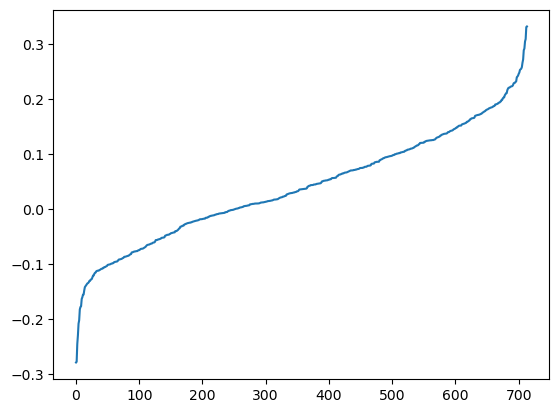

fit df.shape (184002, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.1324 - mse: 1.0002 - weighted_mse: 0.9990 - cosine_similarity: 0.0517 - val_loss: 0.6885 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.6975e-03 - 3s/epoch - 716ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.1324 - mse: 1.0002 - weighted_mse: 0.9990 - cosine_similarity: 0.0527 - val_loss: 0.6885 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -9.0822e-04 - 848ms/epoch - 212ms/step
Epoch 3/1000
4/4 - 1s - loss: 1.1322 - mse: 1.0002 - weighted_mse: 0.9988 - cosine_similarity: 0.0590 - val_loss: 0.6884 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -5.8894e-04 - 840ms/epoch - 210ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.1320 - mse: 1.0002 - weighted_mse: 0.9986 - cosine_similarity: 0.0666 - val_loss: 0.6884 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -4.4246e-04 - 834ms/epoch - 208ms/step
Epoch 5/1000
4/4 - 1s - l

INFO:tensorflow:Assets written to: /tmp/tmpzqlaaiyr/assets
2022-10-29 17:14:40.600646: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:40.600726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:40.600985: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzqlaaiyr
2022-10-29 17:14:40.602725: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:40.602820: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzqlaaiyr
2022-10-29 17:14:40.609156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:40.682127: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzqlaaiyr
2022-10-29 17:14:40.697841: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu_03ccep/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_03ccep/assets
2022-10-29 17:14:42.210372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:42.210443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:42.210618: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu_03ccep
2022-10-29 17:14:42.212270: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:42.212306: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu_03ccep
2022-10-29 17:14:42.218053: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:42.283745: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu_03ccep
2022-10-29 17:14:42.298075: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4kkjpt10/assets


INFO:tensorflow:Assets written to: /tmp/tmp4kkjpt10/assets
2022-10-29 17:14:43.722023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:43.722091: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:43.722264: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4kkjpt10
2022-10-29 17:14:43.723870: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:43.723905: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4kkjpt10
2022-10-29 17:14:43.729402: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:43.793243: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4kkjpt10
2022-10-29 17:14:43.807754: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps8sjq87k/assets


INFO:tensorflow:Assets written to: /tmp/tmps8sjq87k/assets
2022-10-29 17:14:45.186182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:45.186247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:45.186411: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps8sjq87k
2022-10-29 17:14:45.187918: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:45.187952: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps8sjq87k
2022-10-29 17:14:45.193122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:45.252834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps8sjq87k
2022-10-29 17:14:45.265691: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy0giteb6/assets


INFO:tensorflow:Assets written to: /tmp/tmpy0giteb6/assets
2022-10-29 17:14:46.565808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:46.565874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:46.566044: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy0giteb6
2022-10-29 17:14:46.567472: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:46.567506: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy0giteb6
2022-10-29 17:14:46.572630: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:46.631332: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy0giteb6
2022-10-29 17:14:46.644103: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnyoywcav/assets


INFO:tensorflow:Assets written to: /tmp/tmpnyoywcav/assets
2022-10-29 17:14:47.877736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:47.877800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:47.877950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnyoywcav
2022-10-29 17:14:47.879356: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:47.879389: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnyoywcav
2022-10-29 17:14:47.884292: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:47.941192: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnyoywcav
2022-10-29 17:14:47.953943: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpahme6jna/assets


INFO:tensorflow:Assets written to: /tmp/tmpahme6jna/assets
2022-10-29 17:14:49.176092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:49.176163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:49.176370: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpahme6jna
2022-10-29 17:14:49.177748: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:49.177780: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpahme6jna
2022-10-29 17:14:49.182845: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:49.238264: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpahme6jna
2022-10-29 17:14:49.250345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn1kx1t6x/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1kx1t6x/assets
2022-10-29 17:14:51.783947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:51.784013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:51.784178: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn1kx1t6x
2022-10-29 17:14:51.786216: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:51.786251: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn1kx1t6x
2022-10-29 17:14:51.793843: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:51.861847: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn1kx1t6x
2022-10-29 17:14:51.878532: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1zs5hlw0/assets


INFO:tensorflow:Assets written to: /tmp/tmp1zs5hlw0/assets
2022-10-29 17:14:53.137928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:53.137989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:53.138162: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1zs5hlw0
2022-10-29 17:14:53.139620: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:53.139698: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1zs5hlw0
2022-10-29 17:14:53.144957: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:53.201910: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1zs5hlw0
2022-10-29 17:14:53.214603: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoerq0utr/assets


INFO:tensorflow:Assets written to: /tmp/tmpoerq0utr/assets
2022-10-29 17:14:54.389854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:14:54.389921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:14:54.390068: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoerq0utr
2022-10-29 17:14:54.391447: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:14:54.391479: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoerq0utr
2022-10-29 17:14:54.396601: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:14:54.453805: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoerq0utr
2022-10-29 17:14:54.465839: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

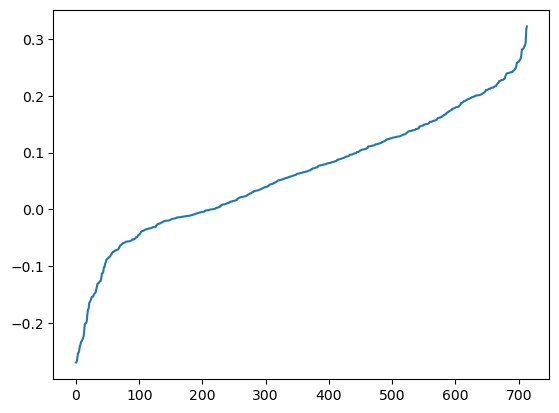

fit df.shape (176870, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.0733 - mse: 1.0002 - weighted_mse: 0.9992 - cosine_similarity: 0.0529 - val_loss: 0.8270 - val_mse: 1.0003 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0043 - 3s/epoch - 698ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.0733 - mse: 1.0002 - weighted_mse: 0.9992 - cosine_similarity: 0.0534 - val_loss: 0.8270 - val_mse: 1.0003 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0046 - 797ms/epoch - 199ms/step
Epoch 3/1000
4/4 - 1s - loss: 1.0732 - mse: 1.0002 - weighted_mse: 0.9991 - cosine_similarity: 0.0593 - val_loss: 0.8270 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0015 - 774ms/epoch - 193ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.0730 - mse: 1.0002 - weighted_mse: 0.9989 - cosine_similarity: 0.0659 - val_loss: 0.8270 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 3.3795e-04 - 815ms/epoch - 204ms/step
Epoch 5/1000
4/4 - 1s - loss: 1.0727 - ms

INFO:tensorflow:Assets written to: /tmp/tmpx3_hwuml/assets
2022-10-29 17:29:22.733063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:22.733145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:22.733350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx3_hwuml
2022-10-29 17:29:22.735318: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:22.735361: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx3_hwuml
2022-10-29 17:29:22.742175: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:22.820068: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx3_hwuml
2022-10-29 17:29:22.838166: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzi4tj2_c/assets


INFO:tensorflow:Assets written to: /tmp/tmpzi4tj2_c/assets
2022-10-29 17:29:24.584255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:24.584333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:24.584528: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzi4tj2_c
2022-10-29 17:29:24.586341: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:24.586381: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzi4tj2_c
2022-10-29 17:29:24.592610: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:24.666619: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzi4tj2_c
2022-10-29 17:29:24.682342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpux78n7od/assets


INFO:tensorflow:Assets written to: /tmp/tmpux78n7od/assets
2022-10-29 17:29:26.330208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:26.330309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:26.330507: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpux78n7od
2022-10-29 17:29:26.332510: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:26.332556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpux78n7od
2022-10-29 17:29:26.338963: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:26.409865: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpux78n7od
2022-10-29 17:29:26.425529: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps2oeeiot/assets


INFO:tensorflow:Assets written to: /tmp/tmps2oeeiot/assets
2022-10-29 17:29:27.960108: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:27.960176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:27.960365: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps2oeeiot
2022-10-29 17:29:27.962080: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:27.962119: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps2oeeiot
2022-10-29 17:29:27.968256: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:28.037275: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps2oeeiot
2022-10-29 17:29:28.052017: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1y_dhuwf/assets


INFO:tensorflow:Assets written to: /tmp/tmp1y_dhuwf/assets
2022-10-29 17:29:29.484113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:29.484188: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:29.484366: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1y_dhuwf
2022-10-29 17:29:29.486002: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:29.486038: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1y_dhuwf
2022-10-29 17:29:29.491741: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:29.556997: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1y_dhuwf
2022-10-29 17:29:29.571510: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoez7cuic/assets


INFO:tensorflow:Assets written to: /tmp/tmpoez7cuic/assets
2022-10-29 17:29:30.998616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:30.998693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:30.998931: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoez7cuic
2022-10-29 17:29:31.000489: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:31.000526: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoez7cuic
2022-10-29 17:29:31.006065: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:31.069555: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoez7cuic
2022-10-29 17:29:31.083385: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb95o5zs7/assets


INFO:tensorflow:Assets written to: /tmp/tmpb95o5zs7/assets
2022-10-29 17:29:32.388495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:32.388564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:32.388731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb95o5zs7
2022-10-29 17:29:32.390275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:32.390315: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb95o5zs7
2022-10-29 17:29:32.395414: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:32.455217: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb95o5zs7
2022-10-29 17:29:32.468135: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkufgyq35/assets


INFO:tensorflow:Assets written to: /tmp/tmpkufgyq35/assets
2022-10-29 17:29:33.791069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:33.791140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:33.791309: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkufgyq35
2022-10-29 17:29:33.792786: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:33.792821: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkufgyq35
2022-10-29 17:29:33.798012: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:33.856975: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkufgyq35
2022-10-29 17:29:33.870298: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyzvtbag4/assets


INFO:tensorflow:Assets written to: /tmp/tmpyzvtbag4/assets
2022-10-29 17:29:35.148164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:35.148228: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:35.148387: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyzvtbag4
2022-10-29 17:29:35.149780: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:35.149812: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyzvtbag4
2022-10-29 17:29:35.154764: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:35.211421: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyzvtbag4
2022-10-29 17:29:35.224885: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphmucrzn6/assets


INFO:tensorflow:Assets written to: /tmp/tmphmucrzn6/assets
2022-10-29 17:29:36.496276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:29:36.496344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:29:36.496501: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphmucrzn6
2022-10-29 17:29:36.497859: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:29:36.497891: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphmucrzn6
2022-10-29 17:29:36.502804: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:29:36.560101: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphmucrzn6
2022-10-29 17:29:36.572229: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

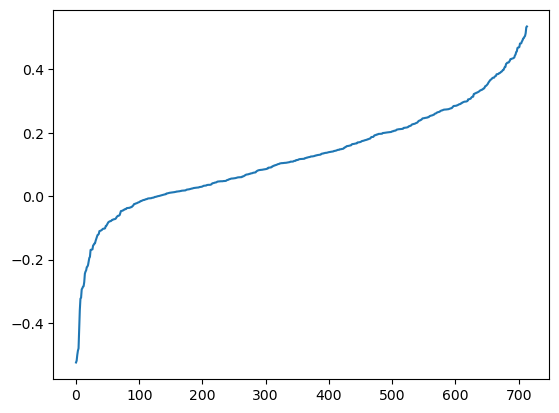

fit df.shape (176870, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.1332 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0590 - val_loss: 0.6860 - val_mse: 1.0003 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0089 - 3s/epoch - 799ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.1332 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0594 - val_loss: 0.6860 - val_mse: 1.0003 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0090 - 818ms/epoch - 204ms/step
Epoch 3/1000
4/4 - 2s - loss: 1.1330 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0663 - val_loss: 0.6860 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0077 - 2s/epoch - 435ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.1328 - mse: 1.0001 - weighted_mse: 0.9984 - cosine_similarity: 0.0746 - val_loss: 0.6860 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0097 - 829ms/epoch - 207ms/step
Epoch 5/1000
4/4 - 1s - loss: 1.1325 - mse: 1.00

INFO:tensorflow:Assets written to: /tmp/tmp8uh63mc4/assets
2022-10-29 17:46:44.362841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:44.362934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:44.363140: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8uh63mc4
2022-10-29 17:46:44.365019: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:44.365061: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8uh63mc4
2022-10-29 17:46:44.371417: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:44.446078: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8uh63mc4
2022-10-29 17:46:44.462519: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpadlcedax/assets


INFO:tensorflow:Assets written to: /tmp/tmpadlcedax/assets
2022-10-29 17:46:46.160083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:46.160170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:46.160370: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpadlcedax
2022-10-29 17:46:46.162214: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:46.162255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpadlcedax
2022-10-29 17:46:46.168728: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:46.245418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpadlcedax
2022-10-29 17:46:46.262364: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprmhv3ix5/assets


INFO:tensorflow:Assets written to: /tmp/tmprmhv3ix5/assets
2022-10-29 17:46:47.870113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:47.870189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:47.870377: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprmhv3ix5
2022-10-29 17:46:47.872165: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:47.872206: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprmhv3ix5
2022-10-29 17:46:47.878424: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:47.950305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprmhv3ix5
2022-10-29 17:46:47.966521: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptihrb0ed/assets


INFO:tensorflow:Assets written to: /tmp/tmptihrb0ed/assets
2022-10-29 17:46:49.510718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:49.510796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:49.510983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptihrb0ed
2022-10-29 17:46:49.512713: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:49.512749: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptihrb0ed
2022-10-29 17:46:49.518480: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:49.586952: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptihrb0ed
2022-10-29 17:46:49.601827: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppx1fb96z/assets


INFO:tensorflow:Assets written to: /tmp/tmppx1fb96z/assets
2022-10-29 17:46:51.053157: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:51.053238: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:51.053421: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppx1fb96z
2022-10-29 17:46:51.055079: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:51.055117: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppx1fb96z
2022-10-29 17:46:51.060887: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:51.127655: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppx1fb96z
2022-10-29 17:46:51.141919: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8fta0lu7/assets


INFO:tensorflow:Assets written to: /tmp/tmp8fta0lu7/assets
2022-10-29 17:46:52.595705: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:52.595781: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:52.595974: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8fta0lu7
2022-10-29 17:46:52.597713: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:52.597743: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8fta0lu7
2022-10-29 17:46:52.603255: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:52.666776: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8fta0lu7
2022-10-29 17:46:52.680542: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa920oqkt/assets


INFO:tensorflow:Assets written to: /tmp/tmpa920oqkt/assets
2022-10-29 17:46:54.068478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:54.068555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:54.068778: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa920oqkt
2022-10-29 17:46:54.070310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:54.070347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa920oqkt
2022-10-29 17:46:54.076137: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:54.137597: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa920oqkt
2022-10-29 17:46:54.150753: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsi4_gy8r/assets


INFO:tensorflow:Assets written to: /tmp/tmpsi4_gy8r/assets
2022-10-29 17:46:55.467837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:55.467905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:55.468072: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsi4_gy8r
2022-10-29 17:46:55.469564: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:55.469599: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsi4_gy8r
2022-10-29 17:46:55.474887: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:55.534321: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsi4_gy8r
2022-10-29 17:46:55.547942: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiwqmwvag/assets


INFO:tensorflow:Assets written to: /tmp/tmpiwqmwvag/assets
2022-10-29 17:46:56.845285: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:56.845350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:56.845555: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiwqmwvag
2022-10-29 17:46:56.846991: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:56.847023: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiwqmwvag
2022-10-29 17:46:56.852123: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:56.910961: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiwqmwvag
2022-10-29 17:46:56.924019: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoyo3ko3j/assets


INFO:tensorflow:Assets written to: /tmp/tmpoyo3ko3j/assets
2022-10-29 17:46:58.203979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 17:46:58.204045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 17:46:58.204204: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoyo3ko3j
2022-10-29 17:46:58.205604: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 17:46:58.205637: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoyo3ko3j
2022-10-29 17:46:58.210594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 17:46:58.266976: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoyo3ko3j
2022-10-29 17:46:58.279326: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

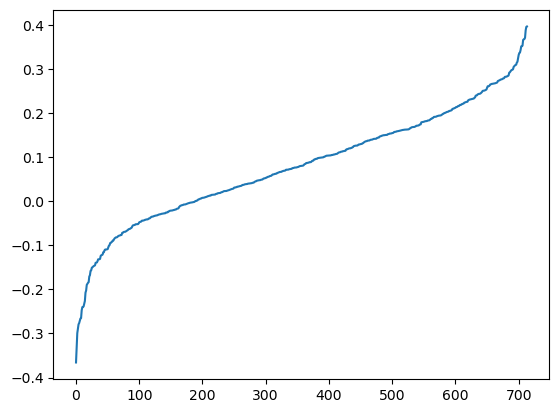

fit df.shape (177320, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.0577 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0614 - val_loss: 0.8622 - val_mse: 1.0002 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0332 - 3s/epoch - 730ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.0577 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0622 - val_loss: 0.8622 - val_mse: 1.0002 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0346 - 816ms/epoch - 204ms/step
Epoch 3/1000
4/4 - 1s - loss: 1.0575 - mse: 1.0001 - weighted_mse: 0.9987 - cosine_similarity: 0.0670 - val_loss: 0.8621 - val_mse: 1.0002 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0396 - 928ms/epoch - 232ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.0573 - mse: 1.0001 - weighted_mse: 0.9984 - cosine_similarity: 0.0745 - val_loss: 0.8621 - val_mse: 1.0002 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0466 - 829ms/epoch - 207ms/step
Epoch 5/1000
4/4 - 1s - loss: 1.0570 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmp8qjdlaft/assets
2022-10-29 18:07:41.611541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:41.611618: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:41.611867: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8qjdlaft
2022-10-29 18:07:41.613622: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:41.613661: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8qjdlaft
2022-10-29 18:07:41.619932: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:41.691845: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8qjdlaft
2022-10-29 18:07:41.707481: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk8fob1xo/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8fob1xo/assets
2022-10-29 18:07:43.253543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:43.253617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:43.253859: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk8fob1xo
2022-10-29 18:07:43.255582: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:43.255620: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk8fob1xo
2022-10-29 18:07:43.261768: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:43.332561: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk8fob1xo
2022-10-29 18:07:43.347850: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplkt5d6ei/assets


INFO:tensorflow:Assets written to: /tmp/tmplkt5d6ei/assets
2022-10-29 18:07:44.815283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:44.815348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:44.815522: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplkt5d6ei
2022-10-29 18:07:44.817168: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:44.817203: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplkt5d6ei
2022-10-29 18:07:44.822685: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:44.886627: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplkt5d6ei
2022-10-29 18:07:44.900566: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpveqatidn/assets


INFO:tensorflow:Assets written to: /tmp/tmpveqatidn/assets
2022-10-29 18:07:46.328154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:46.328222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:46.328392: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpveqatidn
2022-10-29 18:07:46.329909: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:46.329944: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpveqatidn
2022-10-29 18:07:46.335414: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:46.399296: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpveqatidn
2022-10-29 18:07:46.412967: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw49kdjli/assets


INFO:tensorflow:Assets written to: /tmp/tmpw49kdjli/assets
2022-10-29 18:07:47.726741: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:47.726868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:47.727035: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw49kdjli
2022-10-29 18:07:47.728518: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:47.728552: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw49kdjli
2022-10-29 18:07:47.733780: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:47.794360: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw49kdjli
2022-10-29 18:07:47.807396: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_8al0gap/assets


INFO:tensorflow:Assets written to: /tmp/tmp_8al0gap/assets
2022-10-29 18:07:49.099241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:49.099304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:49.099465: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_8al0gap
2022-10-29 18:07:49.100949: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:49.100982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_8al0gap
2022-10-29 18:07:49.106016: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:49.164337: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_8al0gap
2022-10-29 18:07:49.177401: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpne7iej7o/assets


INFO:tensorflow:Assets written to: /tmp/tmpne7iej7o/assets
2022-10-29 18:07:50.421898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:50.421964: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:50.422121: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpne7iej7o
2022-10-29 18:07:50.423533: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:50.423566: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpne7iej7o
2022-10-29 18:07:50.428501: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:50.485012: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpne7iej7o
2022-10-29 18:07:50.497378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkpr11avn/assets


INFO:tensorflow:Assets written to: /tmp/tmpkpr11avn/assets
2022-10-29 18:07:51.714371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:51.714434: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:51.714592: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkpr11avn
2022-10-29 18:07:51.715998: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:51.716030: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkpr11avn
2022-10-29 18:07:51.720827: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:51.776151: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkpr11avn
2022-10-29 18:07:51.788363: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_ckp2iwf/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ckp2iwf/assets
2022-10-29 18:07:53.001161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:53.001221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:53.001369: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_ckp2iwf
2022-10-29 18:07:53.002680: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:53.002712: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_ckp2iwf
2022-10-29 18:07:53.007358: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:53.060353: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_ckp2iwf
2022-10-29 18:07:53.072289: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8mt6vcj_/assets


INFO:tensorflow:Assets written to: /tmp/tmp8mt6vcj_/assets
2022-10-29 18:07:54.237935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 18:07:54.237994: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 18:07:54.238143: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8mt6vcj_
2022-10-29 18:07:54.239457: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 18:07:54.239488: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8mt6vcj_
2022-10-29 18:07:54.244263: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 18:07:54.297109: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8mt6vcj_
2022-10-29 18:07:54.308776: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

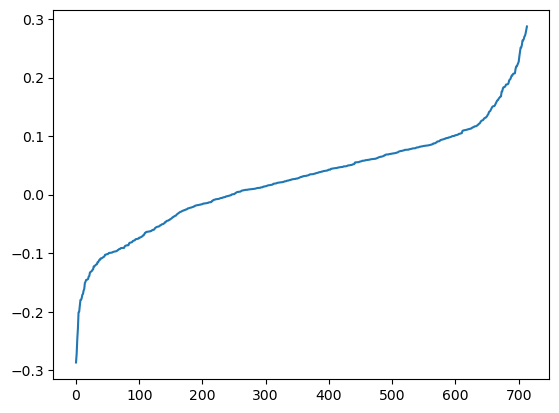

return without cost statistics
mean 0.0035573040404250993
std 0.01671210931134937
sharpe 0.21285787294421876
double sharpe 1.5385553479102023
max drawdown 0.26398961752676103
return with cost statistics
mean 0.0024301227764007447
std 0.01671941733735039
sharpe 0.1453473364153645
double sharpe 0.9744469805028995
max drawdown 0.26397185760589553


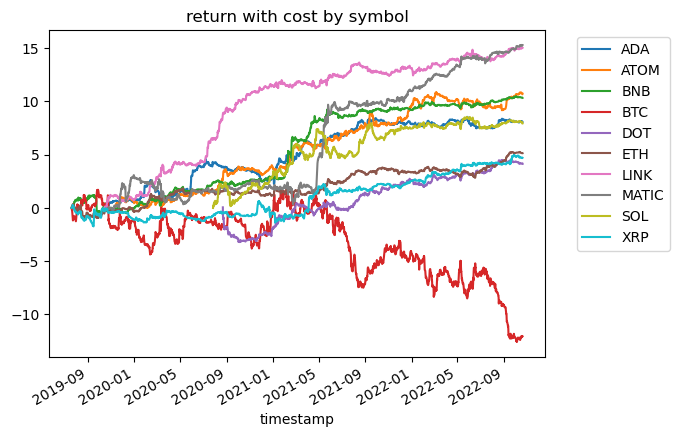

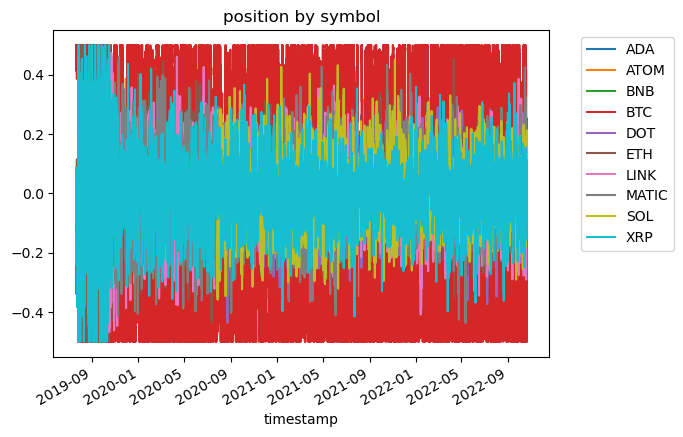

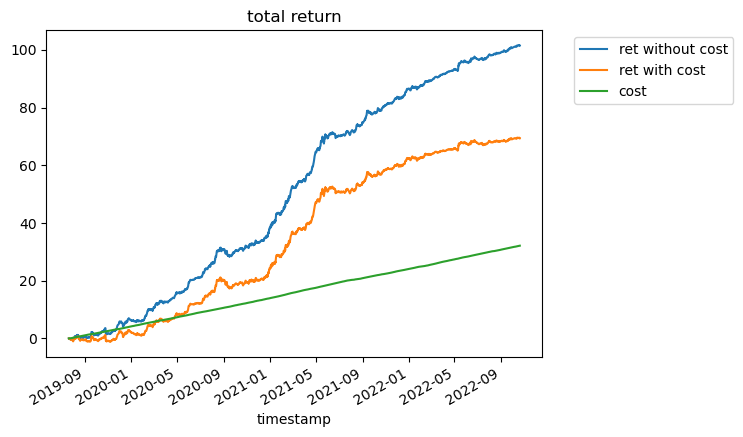

fit df.shape (228683, 730)
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmpzqgyhxfc/assets
2022-10-29 20:46:29.721375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:29.721460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:29.721666: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzqgyhxfc
2022-10-29 20:46:29.723598: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:29.723642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzqgyhxfc
2022-10-29 20:46:29.730311: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:29.812038: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzqgyhxfc
2022-10-29 20:46:29.828858: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd2j5yaa3/assets


INFO:tensorflow:Assets written to: /tmp/tmpd2j5yaa3/assets
2022-10-29 20:46:31.521221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:31.521298: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:31.521495: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd2j5yaa3
2022-10-29 20:46:31.523341: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:31.523382: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd2j5yaa3
2022-10-29 20:46:31.529781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:31.603929: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd2j5yaa3
2022-10-29 20:46:31.619898: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd55eqxfv/assets


INFO:tensorflow:Assets written to: /tmp/tmpd55eqxfv/assets
2022-10-29 20:46:33.270642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:33.270720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:33.270966: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd55eqxfv
2022-10-29 20:46:33.272707: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:33.272747: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd55eqxfv
2022-10-29 20:46:33.280480: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:33.354408: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd55eqxfv
2022-10-29 20:46:33.370471: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphsleow40/assets


INFO:tensorflow:Assets written to: /tmp/tmphsleow40/assets
2022-10-29 20:46:34.897383: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:34.897455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:34.897636: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphsleow40
2022-10-29 20:46:34.899478: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:34.899517: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphsleow40
2022-10-29 20:46:34.906779: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:34.975395: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphsleow40
2022-10-29 20:46:34.990175: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdyhvz142/assets


INFO:tensorflow:Assets written to: /tmp/tmpdyhvz142/assets
2022-10-29 20:46:36.435030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:36.435101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:36.435275: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdyhvz142
2022-10-29 20:46:36.437021: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:36.437057: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdyhvz142
2022-10-29 20:46:36.444125: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:36.509295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdyhvz142
2022-10-29 20:46:36.523191: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxwk0cwh8/assets


INFO:tensorflow:Assets written to: /tmp/tmpxwk0cwh8/assets
2022-10-29 20:46:37.952724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:37.952791: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:37.952961: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxwk0cwh8
2022-10-29 20:46:37.954575: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:37.954681: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxwk0cwh8
2022-10-29 20:46:37.961403: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:38.023748: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxwk0cwh8
2022-10-29 20:46:38.037134: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpby7vk8b_/assets


INFO:tensorflow:Assets written to: /tmp/tmpby7vk8b_/assets
2022-10-29 20:46:39.365758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:39.365822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:39.366039: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpby7vk8b_
2022-10-29 20:46:39.367674: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:39.367710: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpby7vk8b_
2022-10-29 20:46:39.376117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:39.438700: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpby7vk8b_
2022-10-29 20:46:39.451681: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf6p2m8yv/assets


INFO:tensorflow:Assets written to: /tmp/tmpf6p2m8yv/assets
2022-10-29 20:46:40.739882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:40.739947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:40.740108: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf6p2m8yv
2022-10-29 20:46:40.741600: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:40.741681: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf6p2m8yv
2022-10-29 20:46:40.748045: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:40.807342: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf6p2m8yv
2022-10-29 20:46:40.821513: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo0l9y2mv/assets


INFO:tensorflow:Assets written to: /tmp/tmpo0l9y2mv/assets
2022-10-29 20:46:42.085384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:42.085448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:42.085643: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo0l9y2mv
2022-10-29 20:46:42.087101: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:42.087134: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo0l9y2mv
2022-10-29 20:46:42.093385: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:42.151344: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo0l9y2mv
2022-10-29 20:46:42.163737: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbvqrxaid/assets


INFO:tensorflow:Assets written to: /tmp/tmpbvqrxaid/assets
2022-10-29 20:46:46.137517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:46.137582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:46.137789: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbvqrxaid
2022-10-29 20:46:46.139776: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:46.139808: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbvqrxaid
2022-10-29 20:46:46.146988: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:46.212345: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbvqrxaid
2022-10-29 20:46:46.228021: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqq31qd5e/assets


INFO:tensorflow:Assets written to: /tmp/tmpqq31qd5e/assets
2022-10-29 20:46:47.470552: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:47.470615: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:47.470811: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqq31qd5e
2022-10-29 20:46:47.472390: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:47.472424: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqq31qd5e
2022-10-29 20:46:47.478570: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:47.539876: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqq31qd5e
2022-10-29 20:46:47.553980: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb775rvdh/assets


INFO:tensorflow:Assets written to: /tmp/tmpb775rvdh/assets
2022-10-29 20:46:48.772873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:48.772935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:48.773082: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb775rvdh
2022-10-29 20:46:48.774565: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:48.774598: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb775rvdh
2022-10-29 20:46:48.780112: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:48.839721: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb775rvdh
2022-10-29 20:46:48.852938: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9gf6thhi/assets


INFO:tensorflow:Assets written to: /tmp/tmp9gf6thhi/assets
2022-10-29 20:46:50.043809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:50.043872: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:50.044023: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9gf6thhi
2022-10-29 20:46:50.045459: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:50.045492: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9gf6thhi
2022-10-29 20:46:50.050768: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:50.108183: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9gf6thhi
2022-10-29 20:46:50.120515: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnn0yx36u/assets


INFO:tensorflow:Assets written to: /tmp/tmpnn0yx36u/assets
2022-10-29 20:46:51.307547: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:51.307612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:51.307807: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnn0yx36u
2022-10-29 20:46:51.309255: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:51.309289: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnn0yx36u
2022-10-29 20:46:51.314609: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:51.371573: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnn0yx36u
2022-10-29 20:46:51.383985: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcihzug6t/assets


INFO:tensorflow:Assets written to: /tmp/tmpcihzug6t/assets
2022-10-29 20:46:52.562153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:52.562214: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:52.562363: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcihzug6t
2022-10-29 20:46:52.563794: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:52.563826: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcihzug6t
2022-10-29 20:46:52.568866: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:52.624613: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcihzug6t
2022-10-29 20:46:52.636686: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd4kcu1rp/assets


INFO:tensorflow:Assets written to: /tmp/tmpd4kcu1rp/assets
2022-10-29 20:46:53.826526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:53.826588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:53.826777: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd4kcu1rp
2022-10-29 20:46:53.828121: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:53.828152: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd4kcu1rp
2022-10-29 20:46:53.833265: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:53.888278: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd4kcu1rp
2022-10-29 20:46:53.900296: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsj8ref1e/assets


INFO:tensorflow:Assets written to: /tmp/tmpsj8ref1e/assets
2022-10-29 20:46:55.110661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:55.110721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:55.110869: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsj8ref1e
2022-10-29 20:46:55.112221: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:55.112251: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsj8ref1e
2022-10-29 20:46:55.117135: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:55.170636: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsj8ref1e
2022-10-29 20:46:55.182137: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1adkc1vv/assets


INFO:tensorflow:Assets written to: /tmp/tmp1adkc1vv/assets
2022-10-29 20:46:56.352384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:56.352447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:56.352601: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1adkc1vv
2022-10-29 20:46:56.353979: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:56.354010: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1adkc1vv
2022-10-29 20:46:56.358797: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:56.412770: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1adkc1vv
2022-10-29 20:46:56.424635: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiy5l9tn5/assets


INFO:tensorflow:Assets written to: /tmp/tmpiy5l9tn5/assets
2022-10-29 20:46:57.605014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:57.605078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:57.605232: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiy5l9tn5
2022-10-29 20:46:57.606570: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:57.606601: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiy5l9tn5
2022-10-29 20:46:57.611357: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:57.664619: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiy5l9tn5
2022-10-29 20:46:57.676195: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp39ba4h2q/assets


INFO:tensorflow:Assets written to: /tmp/tmp39ba4h2q/assets
2022-10-29 20:46:58.857075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:46:58.857138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:46:58.857293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp39ba4h2q
2022-10-29 20:46:58.858627: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:46:58.858704: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp39ba4h2q
2022-10-29 20:46:58.863420: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:46:58.916833: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp39ba4h2q
2022-10-29 20:46:58.928380: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk_cuqtis/assets


INFO:tensorflow:Assets written to: /tmp/tmpk_cuqtis/assets
2022-10-29 20:47:00.089255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:00.089318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:00.089508: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk_cuqtis
2022-10-29 20:47:00.090835: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:00.090862: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk_cuqtis
2022-10-29 20:47:00.095503: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:00.148968: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk_cuqtis
2022-10-29 20:47:00.160552: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ufldo13/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ufldo13/assets
2022-10-29 20:47:01.317231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:01.317295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:01.317485: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ufldo13
2022-10-29 20:47:01.318819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:01.318850: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ufldo13
2022-10-29 20:47:01.323572: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:01.376613: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ufldo13
2022-10-29 20:47:01.388573: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8lv22bz3/assets


INFO:tensorflow:Assets written to: /tmp/tmp8lv22bz3/assets
2022-10-29 20:47:02.548880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:02.548942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:02.549094: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8lv22bz3
2022-10-29 20:47:02.550431: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:02.550464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8lv22bz3
2022-10-29 20:47:02.555196: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:02.608106: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8lv22bz3
2022-10-29 20:47:02.619646: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp27yh6l1r/assets


INFO:tensorflow:Assets written to: /tmp/tmp27yh6l1r/assets
2022-10-29 20:47:03.805464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:03.805531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:03.805754: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp27yh6l1r
2022-10-29 20:47:03.807113: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:03.807146: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp27yh6l1r
2022-10-29 20:47:03.811894: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:03.865941: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp27yh6l1r
2022-10-29 20:47:03.877840: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvk4oeve3/assets


INFO:tensorflow:Assets written to: /tmp/tmpvk4oeve3/assets
2022-10-29 20:47:05.000742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:05.000801: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:05.000949: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvk4oeve3
2022-10-29 20:47:05.002293: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:05.002324: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvk4oeve3
2022-10-29 20:47:05.006977: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:05.059243: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvk4oeve3
2022-10-29 20:47:05.070853: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjks13v3f/assets


INFO:tensorflow:Assets written to: /tmp/tmpjks13v3f/assets
2022-10-29 20:47:06.221344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:06.221401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:06.221557: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjks13v3f
2022-10-29 20:47:06.222894: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:06.222925: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjks13v3f
2022-10-29 20:47:06.227591: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:06.281598: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjks13v3f
2022-10-29 20:47:06.293678: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpts8oagte/assets


INFO:tensorflow:Assets written to: /tmp/tmpts8oagte/assets
2022-10-29 20:47:07.446613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:07.446680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:07.446837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpts8oagte
2022-10-29 20:47:07.448182: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:07.448215: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpts8oagte
2022-10-29 20:47:07.452996: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:07.500042: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpts8oagte
2022-10-29 20:47:07.510622: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp49l3qm1v/assets


INFO:tensorflow:Assets written to: /tmp/tmp49l3qm1v/assets
2022-10-29 20:47:08.557841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:08.557892: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:08.558124: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp49l3qm1v
2022-10-29 20:47:08.559340: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:08.559388: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp49l3qm1v
2022-10-29 20:47:08.563615: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:08.613964: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp49l3qm1v
2022-10-29 20:47:08.625144: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnfdprdyn/assets


INFO:tensorflow:Assets written to: /tmp/tmpnfdprdyn/assets
2022-10-29 20:47:09.733447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:09.733500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:09.733631: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnfdprdyn
2022-10-29 20:47:09.734929: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:09.734956: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnfdprdyn
2022-10-29 20:47:09.740460: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:09.788167: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnfdprdyn
2022-10-29 20:47:09.798442: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpglnebgre/assets


INFO:tensorflow:Assets written to: /tmp/tmpglnebgre/assets
2022-10-29 20:47:10.870718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:10.870771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:10.870898: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpglnebgre
2022-10-29 20:47:10.872075: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:10.872102: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpglnebgre
2022-10-29 20:47:10.877257: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:10.925405: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpglnebgre
2022-10-29 20:47:10.935585: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpamyi8xyz/assets


INFO:tensorflow:Assets written to: /tmp/tmpamyi8xyz/assets
2022-10-29 20:47:11.984313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:11.984432: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:11.984647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpamyi8xyz
2022-10-29 20:47:11.985797: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:11.985823: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpamyi8xyz
2022-10-29 20:47:11.991178: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:12.057680: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpamyi8xyz
2022-10-29 20:47:12.067922: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbzh2be9q/assets


INFO:tensorflow:Assets written to: /tmp/tmpbzh2be9q/assets
2022-10-29 20:47:15.954204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:15.954268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:15.954471: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbzh2be9q
2022-10-29 20:47:15.956357: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:15.956389: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbzh2be9q
2022-10-29 20:47:15.963934: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:16.031602: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbzh2be9q
2022-10-29 20:47:16.046717: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiw3h36ah/assets


INFO:tensorflow:Assets written to: /tmp/tmpiw3h36ah/assets
2022-10-29 20:47:17.226756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:17.226810: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:17.226942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiw3h36ah
2022-10-29 20:47:17.228390: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:17.228418: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiw3h36ah
2022-10-29 20:47:17.233944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:17.291304: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiw3h36ah
2022-10-29 20:47:17.302771: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyk18rdks/assets


INFO:tensorflow:Assets written to: /tmp/tmpyk18rdks/assets
2022-10-29 20:47:18.399412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:18.399464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:18.399627: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyk18rdks
2022-10-29 20:47:18.400847: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:18.400874: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyk18rdks
2022-10-29 20:47:18.405781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:18.455640: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyk18rdks
2022-10-29 20:47:18.466851: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp01qdlesu/assets


INFO:tensorflow:Assets written to: /tmp/tmp01qdlesu/assets
2022-10-29 20:47:19.541878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:19.541931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:19.542093: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp01qdlesu
2022-10-29 20:47:19.543434: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:19.543461: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp01qdlesu
2022-10-29 20:47:19.548222: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:19.598835: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp01qdlesu
2022-10-29 20:47:19.609562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfgq8y_7n/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgq8y_7n/assets
2022-10-29 20:47:20.699523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:20.699574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:20.699735: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfgq8y_7n
2022-10-29 20:47:20.701035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:20.701061: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfgq8y_7n
2022-10-29 20:47:20.706035: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:20.763656: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfgq8y_7n
2022-10-29 20:47:20.776048: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq2kfc2dq/assets


INFO:tensorflow:Assets written to: /tmp/tmpq2kfc2dq/assets
2022-10-29 20:47:21.840681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:21.840734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:21.840865: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq2kfc2dq
2022-10-29 20:47:21.842068: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:21.842094: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq2kfc2dq
2022-10-29 20:47:21.846476: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:21.897272: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq2kfc2dq
2022-10-29 20:47:21.907626: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp719ix0oa/assets


INFO:tensorflow:Assets written to: /tmp/tmp719ix0oa/assets
2022-10-29 20:47:22.960016: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:22.960068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:22.960194: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp719ix0oa
2022-10-29 20:47:22.961329: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:22.961354: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp719ix0oa
2022-10-29 20:47:22.965845: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:23.014619: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp719ix0oa
2022-10-29 20:47:23.025576: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps26f4274/assets


INFO:tensorflow:Assets written to: /tmp/tmps26f4274/assets
2022-10-29 20:47:24.094260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:24.094312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:24.094584: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps26f4274
2022-10-29 20:47:24.095731: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:24.095756: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps26f4274
2022-10-29 20:47:24.100175: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:24.157522: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps26f4274
2022-10-29 20:47:24.169334: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmproad1ese/assets


INFO:tensorflow:Assets written to: /tmp/tmproad1ese/assets
2022-10-29 20:47:25.271348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:25.271476: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:25.271692: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmproad1ese
2022-10-29 20:47:25.272834: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:25.272860: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmproad1ese
2022-10-29 20:47:25.277894: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:25.335252: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmproad1ese
2022-10-29 20:47:25.346978: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp17tdojib/assets


INFO:tensorflow:Assets written to: /tmp/tmp17tdojib/assets
2022-10-29 20:47:26.384637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:26.384689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:26.384815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp17tdojib
2022-10-29 20:47:26.385937: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:26.385962: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp17tdojib
2022-10-29 20:47:26.390565: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:26.437541: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp17tdojib
2022-10-29 20:47:26.448250: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9hszymi9/assets


INFO:tensorflow:Assets written to: /tmp/tmp9hszymi9/assets
2022-10-29 20:47:27.523404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:27.523467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:27.523620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9hszymi9
2022-10-29 20:47:27.524981: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:27.525012: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9hszymi9
2022-10-29 20:47:27.530072: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:27.579692: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9hszymi9
2022-10-29 20:47:27.590562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc_t4_j9b/assets


INFO:tensorflow:Assets written to: /tmp/tmpc_t4_j9b/assets
2022-10-29 20:47:28.658612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:28.658662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:28.658861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc_t4_j9b
2022-10-29 20:47:28.660053: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:28.660078: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc_t4_j9b
2022-10-29 20:47:28.665026: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:28.715157: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc_t4_j9b
2022-10-29 20:47:28.726975: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplto88abg/assets


INFO:tensorflow:Assets written to: /tmp/tmplto88abg/assets
2022-10-29 20:47:29.781978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:29.782029: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:29.782157: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplto88abg
2022-10-29 20:47:29.783346: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:29.783372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplto88abg
2022-10-29 20:47:29.788052: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:29.838601: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplto88abg
2022-10-29 20:47:29.848791: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgfa5l9mo/assets


INFO:tensorflow:Assets written to: /tmp/tmpgfa5l9mo/assets
2022-10-29 20:47:30.920780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:30.920835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:30.920966: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgfa5l9mo
2022-10-29 20:47:30.922187: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:30.922213: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgfa5l9mo
2022-10-29 20:47:30.926558: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:30.974271: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgfa5l9mo
2022-10-29 20:47:30.985293: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpevy9lanx/assets


INFO:tensorflow:Assets written to: /tmp/tmpevy9lanx/assets
2022-10-29 20:47:32.039283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:32.039382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:32.039608: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpevy9lanx
2022-10-29 20:47:32.040752: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:32.040778: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpevy9lanx
2022-10-29 20:47:32.045188: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:32.098630: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpevy9lanx
2022-10-29 20:47:32.110830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxbwm9hx3/assets


INFO:tensorflow:Assets written to: /tmp/tmpxbwm9hx3/assets
2022-10-29 20:47:33.160918: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:33.160969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:33.161289: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxbwm9hx3
2022-10-29 20:47:33.162454: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:33.162518: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxbwm9hx3
2022-10-29 20:47:33.166983: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:33.219917: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxbwm9hx3
2022-10-29 20:47:33.235862: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqfudgyfg/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfudgyfg/assets
2022-10-29 20:47:36.453391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:36.453450: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:36.453605: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqfudgyfg
2022-10-29 20:47:36.455565: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:36.455599: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqfudgyfg
2022-10-29 20:47:36.463613: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:36.530278: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqfudgyfg
2022-10-29 20:47:36.544848: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv4ydy1al/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4ydy1al/assets
2022-10-29 20:47:37.701852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:37.701905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:37.702059: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv4ydy1al
2022-10-29 20:47:37.703394: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:37.703422: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv4ydy1al
2022-10-29 20:47:37.709548: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:37.772890: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv4ydy1al
2022-10-29 20:47:37.786484: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpimeffxhu/assets


INFO:tensorflow:Assets written to: /tmp/tmpimeffxhu/assets
2022-10-29 20:47:38.891933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:38.891988: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:38.892154: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpimeffxhu
2022-10-29 20:47:38.893424: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:38.893465: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpimeffxhu
2022-10-29 20:47:38.899112: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:38.958596: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpimeffxhu
2022-10-29 20:47:38.970123: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnezsi_cw/assets


INFO:tensorflow:Assets written to: /tmp/tmpnezsi_cw/assets
2022-10-29 20:47:40.095837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:40.095889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:40.096119: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnezsi_cw
2022-10-29 20:47:40.097280: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:40.097307: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnezsi_cw
2022-10-29 20:47:40.102271: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:40.152374: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnezsi_cw
2022-10-29 20:47:40.165044: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp865kkdf2/assets


INFO:tensorflow:Assets written to: /tmp/tmp865kkdf2/assets
2022-10-29 20:47:41.310736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:41.310799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:41.311006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp865kkdf2
2022-10-29 20:47:41.312503: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:41.312532: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp865kkdf2
2022-10-29 20:47:41.318569: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:41.381726: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp865kkdf2
2022-10-29 20:47:41.395963: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpikmk6_of/assets


INFO:tensorflow:Assets written to: /tmp/tmpikmk6_of/assets
2022-10-29 20:47:42.471392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:42.471445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:42.471606: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpikmk6_of
2022-10-29 20:47:42.472735: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:42.472761: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpikmk6_of
2022-10-29 20:47:42.477251: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:42.526140: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpikmk6_of
2022-10-29 20:47:42.536762: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyc4yls0w/assets


INFO:tensorflow:Assets written to: /tmp/tmpyc4yls0w/assets
2022-10-29 20:47:43.594984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:43.595055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:43.595329: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyc4yls0w
2022-10-29 20:47:43.596580: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:43.596605: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyc4yls0w
2022-10-29 20:47:43.601505: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:43.654305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyc4yls0w
2022-10-29 20:47:43.666593: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpav7_puu6/assets


INFO:tensorflow:Assets written to: /tmp/tmpav7_puu6/assets
2022-10-29 20:47:44.741320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:44.741409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:44.741613: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpav7_puu6
2022-10-29 20:47:44.742806: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:44.742831: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpav7_puu6
2022-10-29 20:47:44.747555: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:44.805642: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpav7_puu6
2022-10-29 20:47:44.817241: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe545s457/assets


INFO:tensorflow:Assets written to: /tmp/tmpe545s457/assets
2022-10-29 20:47:45.906230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:45.906281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:45.906410: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe545s457
2022-10-29 20:47:45.907600: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:45.907628: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe545s457
2022-10-29 20:47:45.912423: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:45.962302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe545s457
2022-10-29 20:47:45.973460: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9rbrsoif/assets


INFO:tensorflow:Assets written to: /tmp/tmp9rbrsoif/assets
2022-10-29 20:47:47.095119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:47.095171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:47.095339: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9rbrsoif
2022-10-29 20:47:47.096522: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:47.096549: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9rbrsoif
2022-10-29 20:47:47.101338: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:47.153079: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9rbrsoif
2022-10-29 20:47:47.165231: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeamxchf4/assets


INFO:tensorflow:Assets written to: /tmp/tmpeamxchf4/assets
2022-10-29 20:47:48.264666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:48.264718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:48.265000: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeamxchf4
2022-10-29 20:47:48.266293: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:48.266318: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeamxchf4
2022-10-29 20:47:48.271204: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:48.324372: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeamxchf4
2022-10-29 20:47:48.336284: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcf6f8dae/assets


INFO:tensorflow:Assets written to: /tmp/tmpcf6f8dae/assets
2022-10-29 20:47:49.415730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:49.415787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:49.415919: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcf6f8dae
2022-10-29 20:47:49.417107: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:49.417133: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcf6f8dae
2022-10-29 20:47:49.421697: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:49.469734: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcf6f8dae
2022-10-29 20:47:49.480617: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps43m9vjc/assets


INFO:tensorflow:Assets written to: /tmp/tmps43m9vjc/assets
2022-10-29 20:47:52.269950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:52.270016: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:52.270222: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps43m9vjc
2022-10-29 20:47:52.272422: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:52.272458: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps43m9vjc
2022-10-29 20:47:52.281468: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:52.355640: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps43m9vjc
2022-10-29 20:47:52.374164: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo49jalbj/assets


INFO:tensorflow:Assets written to: /tmp/tmpo49jalbj/assets
2022-10-29 20:47:53.517790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:53.517843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:53.517974: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo49jalbj
2022-10-29 20:47:53.519426: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:53.519455: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo49jalbj
2022-10-29 20:47:53.526123: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:53.589275: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo49jalbj
2022-10-29 20:47:53.603122: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdl_2gmfn/assets


INFO:tensorflow:Assets written to: /tmp/tmpdl_2gmfn/assets
2022-10-29 20:47:54.723362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:54.723423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:54.723580: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdl_2gmfn
2022-10-29 20:47:54.725321: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:54.725354: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdl_2gmfn
2022-10-29 20:47:54.731737: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:54.797690: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdl_2gmfn
2022-10-29 20:47:54.811659: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5k3cq9ml/assets


INFO:tensorflow:Assets written to: /tmp/tmp5k3cq9ml/assets
2022-10-29 20:47:55.929205: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:55.929266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:55.929412: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5k3cq9ml
2022-10-29 20:47:55.931155: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:55.931192: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5k3cq9ml
2022-10-29 20:47:55.937544: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:55.995298: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5k3cq9ml
2022-10-29 20:47:56.006443: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpav72fbmu/assets


INFO:tensorflow:Assets written to: /tmp/tmpav72fbmu/assets
2022-10-29 20:47:57.103177: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:57.103228: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:57.103355: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpav72fbmu
2022-10-29 20:47:57.104646: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:57.104673: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpav72fbmu
2022-10-29 20:47:57.109425: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:57.159613: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpav72fbmu
2022-10-29 20:47:57.170567: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz2ch19z6/assets


INFO:tensorflow:Assets written to: /tmp/tmpz2ch19z6/assets
2022-10-29 20:47:58.270280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:58.270331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:58.270491: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz2ch19z6
2022-10-29 20:47:58.271759: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:58.271786: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz2ch19z6
2022-10-29 20:47:58.276950: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:58.335872: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz2ch19z6
2022-10-29 20:47:58.347564: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk4go6wn_/assets


INFO:tensorflow:Assets written to: /tmp/tmpk4go6wn_/assets
2022-10-29 20:47:59.432864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:47:59.432915: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:47:59.433148: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk4go6wn_
2022-10-29 20:47:59.434635: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:47:59.434663: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk4go6wn_
2022-10-29 20:47:59.439760: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:47:59.498569: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk4go6wn_
2022-10-29 20:47:59.508782: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv7ixxgga/assets


INFO:tensorflow:Assets written to: /tmp/tmpv7ixxgga/assets
2022-10-29 20:48:00.569827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:00.569882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:00.570049: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv7ixxgga
2022-10-29 20:48:00.571298: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:00.571326: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv7ixxgga
2022-10-29 20:48:00.576207: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:00.629646: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv7ixxgga
2022-10-29 20:48:00.641025: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2dneixdb/assets


INFO:tensorflow:Assets written to: /tmp/tmp2dneixdb/assets
2022-10-29 20:48:01.718755: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:01.718807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:01.719031: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2dneixdb
2022-10-29 20:48:01.720311: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:01.720338: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2dneixdb
2022-10-29 20:48:01.725193: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:01.776636: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2dneixdb
2022-10-29 20:48:01.787788: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvpp_ln_n/assets


INFO:tensorflow:Assets written to: /tmp/tmpvpp_ln_n/assets
2022-10-29 20:48:02.852864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:02.853009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:02.853198: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvpp_ln_n
2022-10-29 20:48:02.854653: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:02.854679: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvpp_ln_n
2022-10-29 20:48:02.859504: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:02.910629: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvpp_ln_n
2022-10-29 20:48:02.921363: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvywvhm9k/assets


INFO:tensorflow:Assets written to: /tmp/tmpvywvhm9k/assets
2022-10-29 20:48:05.466268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:05.466332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:05.466493: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvywvhm9k
2022-10-29 20:48:05.468614: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:05.468647: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvywvhm9k
2022-10-29 20:48:05.478387: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:05.552664: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvywvhm9k
2022-10-29 20:48:05.567805: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcto3n2gg/assets


INFO:tensorflow:Assets written to: /tmp/tmpcto3n2gg/assets
2022-10-29 20:48:06.742068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:06.742123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:06.742255: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcto3n2gg
2022-10-29 20:48:06.743834: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:06.743864: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcto3n2gg
2022-10-29 20:48:06.750705: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:06.812355: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcto3n2gg
2022-10-29 20:48:06.831439: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf_0b7grm/assets


INFO:tensorflow:Assets written to: /tmp/tmpf_0b7grm/assets
2022-10-29 20:48:07.974642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:07.974696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:07.974920: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf_0b7grm
2022-10-29 20:48:07.976342: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:07.976372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf_0b7grm
2022-10-29 20:48:07.982488: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:08.041808: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf_0b7grm
2022-10-29 20:48:08.055791: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4xzinvz9/assets


INFO:tensorflow:Assets written to: /tmp/tmp4xzinvz9/assets
2022-10-29 20:48:09.157005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:09.157058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:09.157186: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4xzinvz9
2022-10-29 20:48:09.158489: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:09.158517: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4xzinvz9
2022-10-29 20:48:09.163843: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:09.224842: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4xzinvz9
2022-10-29 20:48:09.237399: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjahfdeu7/assets


INFO:tensorflow:Assets written to: /tmp/tmpjahfdeu7/assets
2022-10-29 20:48:10.381870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:10.381931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:10.382081: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjahfdeu7
2022-10-29 20:48:10.383724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:10.383753: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjahfdeu7
2022-10-29 20:48:10.389395: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:10.447772: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjahfdeu7
2022-10-29 20:48:10.460722: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpox32rrwx/assets


INFO:tensorflow:Assets written to: /tmp/tmpox32rrwx/assets
2022-10-29 20:48:11.563973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:11.564026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:11.564159: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpox32rrwx
2022-10-29 20:48:11.565614: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:11.565642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpox32rrwx
2022-10-29 20:48:11.570885: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:11.627111: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpox32rrwx
2022-10-29 20:48:11.639503: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi1gzf5do/assets


INFO:tensorflow:Assets written to: /tmp/tmpi1gzf5do/assets
2022-10-29 20:48:12.735820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:12.735869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:12.736123: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi1gzf5do
2022-10-29 20:48:12.737410: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:12.737437: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi1gzf5do
2022-10-29 20:48:12.742131: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:12.794241: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi1gzf5do
2022-10-29 20:48:12.806800: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptjfzw7ux/assets


INFO:tensorflow:Assets written to: /tmp/tmptjfzw7ux/assets
2022-10-29 20:48:13.885141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:13.885193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:13.885321: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptjfzw7ux
2022-10-29 20:48:13.886586: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:13.886614: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptjfzw7ux
2022-10-29 20:48:13.891413: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:13.945089: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptjfzw7ux
2022-10-29 20:48:13.958139: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq5x92e0z/assets


INFO:tensorflow:Assets written to: /tmp/tmpq5x92e0z/assets
2022-10-29 20:48:16.419514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:16.419581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:16.419784: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq5x92e0z
2022-10-29 20:48:16.421901: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:16.421933: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq5x92e0z
2022-10-29 20:48:16.429861: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:16.502217: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq5x92e0z
2022-10-29 20:48:16.518365: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbh4d9tcw/assets


INFO:tensorflow:Assets written to: /tmp/tmpbh4d9tcw/assets
2022-10-29 20:48:17.704353: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:17.704408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:17.704540: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbh4d9tcw
2022-10-29 20:48:17.705944: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:17.705972: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbh4d9tcw
2022-10-29 20:48:17.712024: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:17.768269: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbh4d9tcw
2022-10-29 20:48:17.780308: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzshth1z0/assets


INFO:tensorflow:Assets written to: /tmp/tmpzshth1z0/assets
2022-10-29 20:48:18.882674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-29 20:48:18.882728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-29 20:48:18.883062: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzshth1z0
2022-10-29 20:48:18.884365: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-29 20:48:18.884392: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzshth1z0
2022-10-29 20:48:18.889606: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-29 20:48:18.949770: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzshth1z0
2022-10-29 20:48:18.963515: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [15]:
print(tf.keras.backend.floatx())

df = pd.read_pickle('/tmp/df_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon96_price_type_none.pkl')
# df = df.iloc[-10000:]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221029_btc_one_nn_avg.xz', 'wb') as f:
    f.write(data)

2022-10-29 22:04:51.505099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 22:04:51.619375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-29 22:04:51.619418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-29 22:04:51.647938: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-29 22:04:52.241107: W tensorflow/stream_executor/platform/de

timestamp                  symbol
2022-08-22 09:00:00+00:00  ADA       0.071942
                           ATOM      0.045990
                           BNB       0.065882
                           BTC      -0.500000
                           DOT       0.055578
                                       ...   
2022-10-21 09:00:00+00:00  ETH      -0.039531
                           LINK      0.072621
                           MATIC     0.074976
                           SOL       0.110455
                           XRP      -0.000192
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


/tmp/ipykernel_11022/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_11022/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_11022/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_11022/724680936.py:46: PerformanceWarnin

position1  position2  position3
timestamp                 symbol                                 
2022-08-22 10:00:00+00:00 ADA      0.056774   0.056774   0.060310
                          ATOM     0.061264   0.061264   0.061418
                          BNB      0.057378   0.057378   0.062994
                          BTC     -0.500000  -0.500000  -0.500000
                          DOT      0.051719   0.051719   0.046716
...                                     ...        ...        ...
2022-10-21 08:00:00+00:00 ETH     -0.070963  -0.070963  -0.072130
                          LINK     0.091317   0.091317   0.085622
                          MATIC    0.052172   0.052172   0.051040
                          SOL      0.115885   0.115885   0.117175
                          XRP     -0.033439  -0.033439  -0.033900

[14390 rows x 3 columns]

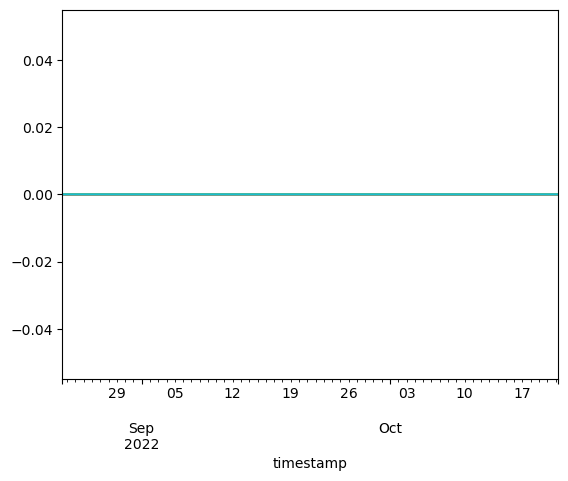

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


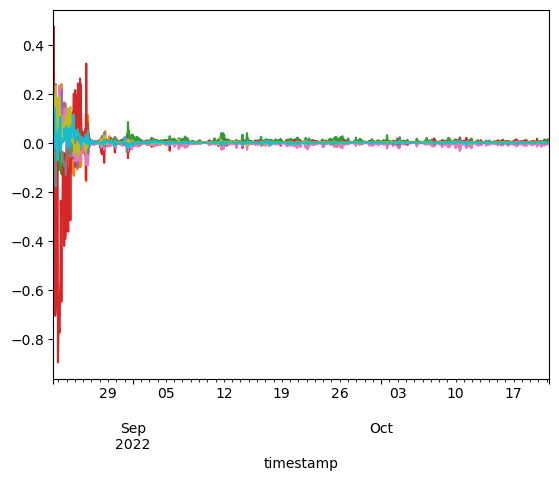

In [1]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221029_btc_one_nn_avg.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

In [ ]:
# https://arxiv.org/pdf/1902.06853.pdf

def eoc_v(f, sigma_w=1.0):
    def v(x):
        n = 10000
        z = np.random.normal(0, 1, n)
        return sigma_w ** 2 * np.mean(f(x ** 0.5 * z) ** 2)
    return v

def eoc_sigma_w(f, f_deriva, sigma_b=0.0):
    f_v = eoc_v(f)
    f_deriva_v = eoc_v(f_deriva)
    q = 0
    for i in range(100):
        q = sigma_b ** 2 + f_v(q) / f_deriva_v(q)
    return 1.0 / f_deriva_v(q) ** 0.5

# def gelu(x):
    
# def gelu_deriva(x):
    
    